In [2]:
import pandas as pd
import numpy as np

/Users/kellywangtingyu/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

btc['MA200'] = btc['Close'].rolling(window=200).mean()
btc['MA50'] = btc['Close'].rolling(window=50).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
btc['STD15'] = btc['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
btc['BB_Upper'] = btc['SMAVG (15)  on Close'] + (btc['STD15'] * 2)
btc['BB_Lower'] = btc['SMAVG (15)  on Close'] - (btc['STD15'] * 2)

# Calculate Bollinger Band Width
btc['BB_Width'] = (btc['BB_Upper'] - btc['BB_Lower']) / btc['SMAVG (15)  on Close']

# Create lagged columns (shift by 1)
lagged_btc = btc.copy()
for col in btc.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_btc[col + '_lag1'] = btc[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_btc = lagged_btc[['Date', 'Close', 'Open'] + [col + '_lag1' for col in btc.columns if col not in ['Date', 'Close']]]

lagged_btc.drop(index=lagged_btc.index[:30], inplace=True)

lagged_btc = lagged_btc[(lagged_btc['Date'] >= '2025-01-01') & (lagged_btc['Date'] < '2025-03-01')]

btc = pd.read_csv("../data/btc_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])

merged = df_btc.merge(lagged_btc, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'BTC_BreakHigh2_lag1'])

In [5]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged.copy().reset_index(drop=True)

# Calculate price change predictions
trading_results2['Predicted_Diff'] = trading_results2['BTC_Predicted'] / trading_results2['Open'] - 1

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0
stop_loss_pct = 0.07  # 5% stop-loss

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'BTC_Actual']
    current_open = trading_results2.at[i, 'Open']
    prev_ma200 = trading_results2.at[i, 'MA200_lag1']
    prev_ma50 = trading_results2.at[i, 'MA50_lag1']
    prev_ma10 = trading_results2.at[i, 'SMAVG (10)  on Close_lag1']
    prev_ma15 = trading_results2.at[i, 'SMAVG (15)  on Close_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']

    if trading_results2.at[i, 'Predicted_Diff'] > 0.003 and current_open <= lowerbb and prev_ma50 > prev_ma200 and prev_ma10 < prev_ma50: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted_Diff'] < -0.0015 and current_open >= upperbb and prev_ma50 < prev_ma200:
        trading_results2.at[i, 'Signal'] = -1

    current_price = trading_results2['BTC_Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 5000:  # Buy
        buy_amount = cash - 5000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Implement stop-loss: if price falls 5% below entry price, sell
    if position > 0 and current_price <= entry_price * (1 - stop_loss_pct):
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Stop-Loss Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1370412632.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.129151490547987' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1370412632.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4902.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1370412632.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '91585.78' has dtype incompatible with int64, please explicitly cast to a co

Total Return: 16.79%
Number of Trades: 4
Maximum Drawdown: 7.41%
Final Portfolio Value: 233,581.30


In [6]:
trading_results2[trading_results2['Trade_Action'] != 'Hold']

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
613,2025-01-13 18:30:00,91585.78,92288.85778,91925.38,91924.50,92802.03,92819.28,91864.91,92725.09,93255.20,...,95164.795075,92098.704925,0.032746,0.003964,1,2.129151,4902.500000,91585.78,199902.500000,Buy
1102,2025-01-23 23:00:00,104232.64,104392.55140,105166.94,105166.94,102382.22,106024.97,102319.31,102620.04,102224.73,...,103705.142386,100730.877614,0.029097,-0.007363,-1,0.000000,226718.617279,0.00,226718.617279,Sell
1691,2025-02-05 05:30:00,96609.38,97644.70980,97259.33,97259.33,98690.38,98701.36,97231.27,98737.73,98955.48,...,100355.380308,97956.559692,0.024192,0.003962,1,2.295001,4889.140691,96609.38,226607.757971,Buy
1820,2025-02-07 22:00:00,99697.81,98524.13948,98839.94,98839.94,97725.30,98882.34,97277.50,98009.52,97709.52,...,98429.084918,96445.415082,0.020358,-0.003195,-1,0.000000,233581.304420,0.00,233581.304420,Sell


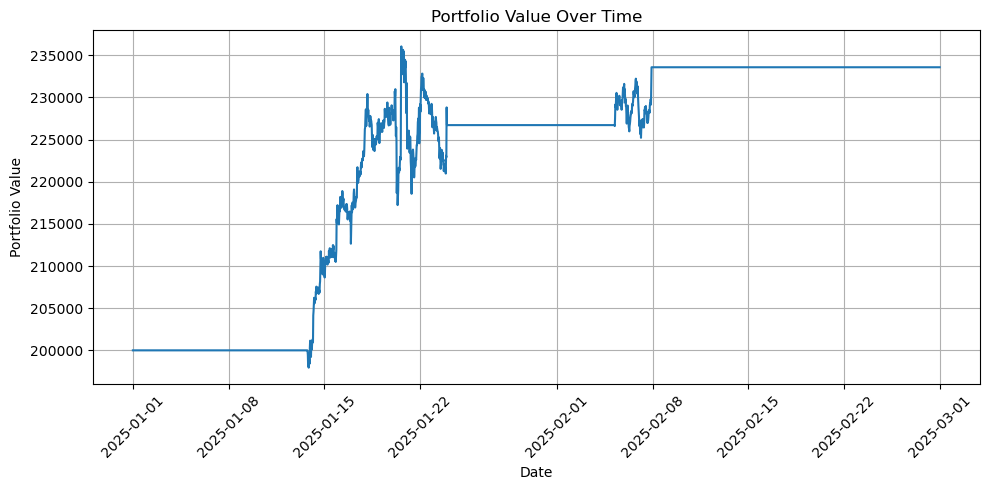

In [7]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results2['Date'], trading_results2['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

In [8]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

spy['MA200'] = spy['Close'].rolling(window=200).mean()
spy['MA20'] = spy['Close'].rolling(window=20).mean()
spy['MA50'] = spy['Close'].rolling(window=50).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['MA20'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['MA20'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

spy['Vol_Mean'] = spy['Volume'].rolling(20).mean()

# Create lagged columns (shift by 1)
lagged_spy = spy.copy()
for col in spy.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_spy[col + '_lag1'] = spy[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_spy = lagged_spy[['Date', 'Close', 'Open'] + [col + '_lag1' for col in spy.columns if col not in ['Date', 'Close']]]

lagged_spy.drop(index=lagged_spy.index[:30], inplace=True)

# Display result
lagged_spy.head()

lagged_spy = lagged_spy[(lagged_spy['Date'] >= '2025-01-01') & (lagged_spy['Date'] < '2025-03-01')]

spy = pd.read_csv("../data/spy_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

merged_spy = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged_spy = merged_spy.drop(columns = ['Unnamed: 0', 'Close', 'SPY_BreakHigh2_lag1'])

In [9]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
trading_results3 = merged_spy.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['SPY_Actual'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100

# Calculate price change predictions
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted'] / trading_results3['Open'] - 1

# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'

for i in range(1, len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    prev_ma200 = trading_results3['MA200_lag1'].iloc[i]
    upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    prev_vol = trading_results3['Volume_lag1'].iloc[i]
    vol_mean = trading_results3['Vol_Mean_lag1'].iloc[i]
    prev_lowerbb = trading_results3.at[i-1, 'BB_Lower_lag1']
    prev_upperbb = trading_results3.at[i-1, 'BB_Upper_lag1']
    volatility = trading_results3.at[i, 'STD15_lag1']

    # Generate trading signals

    if trading_results3.at[i, 'Predicted_Diff'] > 0 and current_open < lowerbb * 1.0008 and ((lowerbb - prev_lowerbb) * (upperbb - prev_upperbb)) < 0 and volatility < 4: 
        trading_results3.at[i, 'Signal'] = 1  # Buy signal
    elif trading_results3.at[i, 'Predicted_Diff'] < 0 and current_open > upperbb and prev_vol > vol_mean:
        trading_results3.at[i, 'Signal'] = -1  # Sell signal
    '''
    if trading_results3.at[i, 'Predicted_Diff'] > 0.0075 and current_open <= lowerbb: 
        trading_results3.at[i, 'Signal'] = 1  # Buy signal
    elif trading_results3.at[i, 'Predicted_Diff'] < 0 and current_open >= upperbb and prev_vol > vol_mean:
        trading_results3.at[i, 'Signal'] = -1  # Sell signal
    '''

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal == 1 and cash > 5000:  # Buy signal
        max_buy_units = int((cash-5000) / (current_price * (1 + commission_rate)))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 9.36%
Buy-and-Hold Return: 0.33%
Number of Trades: 9
Maximum Drawdown: 1.43%
Final Portfolio Value: 874,847.30
Final Cash: 5,071.54
Final Position: 1477
Total Commission Paid: 2,252.48


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/150780238.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5099.551385000115' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/150780238.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799761.601385' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value


In [10]:
trading_results3[trading_results3['Trade_Action'] != 'Hold']

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Vol_Mean_lag1,Predicted_Diff,Signal,Position,Cash,Portfolio_Value,Trade_Action
17,2025-01-03 02:00:00,582.170,583.176368,582.83,582.870,584.280,584.35,580.94,586.028,586.774,...,591.364485,582.454015,0.015195,2743210.75,0.000526,1,1365,5099.551385,799761.601385,Buy
36,2025-01-06 22:30:00,597.924,591.848792,591.95,596.270,591.810,592.21,591.05,591.793,591.143,...,594.535133,581.309867,0.022425,2354618.40,-0.007415,-1,0,821020.961507,821020.961507,Sell
76,2025-01-10 23:00:00,581.898,584.331338,582.35,582.350,585.880,585.95,582.28,587.933,587.857,...,594.655672,582.325228,0.020976,2477105.15,0.003402,1,1401,5537.291778,820776.389778,Buy
114,2025-01-15 22:30:00,591.910,582.322338,582.08,590.325,580.600,582.29,579.58,581.962,581.123,...,584.983709,576.984291,0.013760,2395817.60,-0.013556,-1,0,834554.422005,834554.422005,Sell
270,2025-02-03 22:30:00,591.620,600.686774,601.82,592.670,601.865,603.27,601.05,603.402,606.044,...,611.683854,600.428446,0.018556,2812892.85,0.013527,1,1401,5446.144119,834305.764119,Buy
309,2025-02-06 22:30:00,605.220,604.454528,604.24,605.990,603.740,604.37,602.91,603.451,602.892,...,605.034934,598.918866,0.010156,1608517.60,-0.002534,-1,0,853104.990153,853104.990153,Sell
332,2025-02-08 03:30:00,601.040,600.645374,600.56,600.560,601.150,601.59,600.42,601.778,602.664,...,607.084203,600.732797,0.010526,1980760.20,0.000142,1,1410,5384.350233,852850.750233,Buy
423,2025-02-20 03:30:00,613.080,611.072920,612.79,612.799,611.545,613.08,611.40,611.739,611.165,...,612.275583,608.977717,0.005399,1148452.55,-0.002817,-1,0,869567.817393,869567.817393,Sell
503,2025-02-28 04:30:00,585.130,587.134674,586.68,586.620,589.180,589.35,586.24,590.991,592.242,...,598.783167,587.679333,0.018734,2437814.80,0.000877,1,1477,5071.536290,869308.546290,Buy


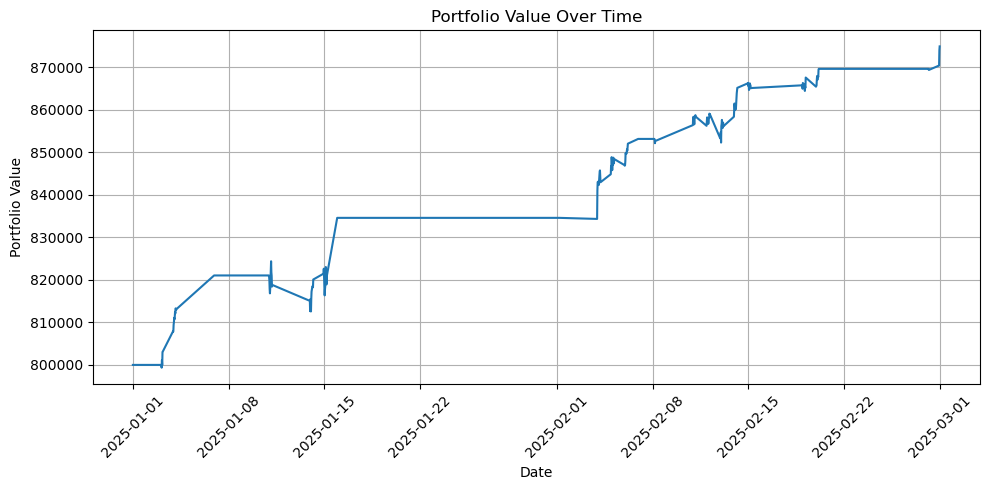

In [11]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

## Combined

In [12]:
combined = trading_results2.merge(trading_results3, on = 'Date', how = 'left')

# Rename columns
combined = combined.rename(columns=lambda x: x.replace('_x', '_BTC').replace('_y', '_SPY'))

combined = combined[['Date', 'BTC_Actual', 'Open_BTC', 'Signal_BTC', 'Position_SPY', 'Cash_BTC', 'Portfolio_Value_BTC', 'Trade_Action_BTC', 'SPY_Actual', 'Open_SPY', 'Signal_SPY', 'Cash_SPY', 'Portfolio_Value_SPY', 'Trade_Action_SPY']]
combined['Cash_SPY'] = combined['Cash_SPY'].ffill()
combined['Portfolio_Value_SPY'] = combined['Portfolio_Value_SPY'].ffill()

combined['Portfolio_Value'] = combined['Portfolio_Value_BTC'] + combined['Portfolio_Value_SPY']
combined

,Date,BTC_Actual,Open_BTC,Signal_BTC,Position_SPY,Cash_BTC,Portfolio_Value_BTC,Trade_Action_BTC,SPY_Actual,Open_SPY,Signal_SPY,Cash_SPY,Portfolio_Value_SPY,Trade_Action_SPY,Portfolio_Value
0,2025-01-01 00:00:00,94819.27,95284.25,0,0.0,200000.00000,200000.00000,Hold,586.900,588.78,0.0,800000.00000,800000.00000,Hold,1.000000e+06
1,2025-01-01 00:30:00,94687.97,94819.27,0,0.0,200000.00000,200000.00000,Hold,587.060,586.88,0.0,800000.00000,800000.00000,Hold,1.000000e+06
2,2025-01-01 01:00:00,94358.80,94686.97,0,0.0,200000.00000,200000.00000,Hold,585.860,587.04,0.0,800000.00000,800000.00000,Hold,1.000000e+06
3,2025-01-01 01:30:00,93961.69,94358.80,0,0.0,200000.00000,200000.00000,Hold,587.205,585.86,0.0,800000.00000,800000.00000,Hold,1.000000e+06
4,2025-01-01 02:00:00,93836.11,93961.44,0,0.0,200000.00000,200000.00000,Hold,584.960,587.12,0.0,800000.00000,800000.00000,Hold,1.000000e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,2025-02-28 21:30:00,81465.09,80695.28,0,NaN,233581.30442,233581.30442,Hold,NaN,NaN,NaN,5071.53629,869308.54629,NaN,1.102890e+06
2828,2025-02-28 22:00:00,81785.98,81468.81,0,NaN,233581.30442,233581.30442,Hold,NaN,NaN,NaN,5071.53629,869308.54629,NaN,1.102890e+06
2829,2025-02-28 22:30:00,82054.27,81787.52,0,1477.0,233581.30442,233581.30442,Hold,585.835,585.56,1.0,5071.53629,870349.83129,Hold,1.103931e+06
2830,2025-02-28 23:00:00,84317.02,82054.27,0,1477.0,233581.30442,233581.30442,Hold,588.250,585.85,0.0,5071.53629,873916.78629,Hold,1.107498e+06


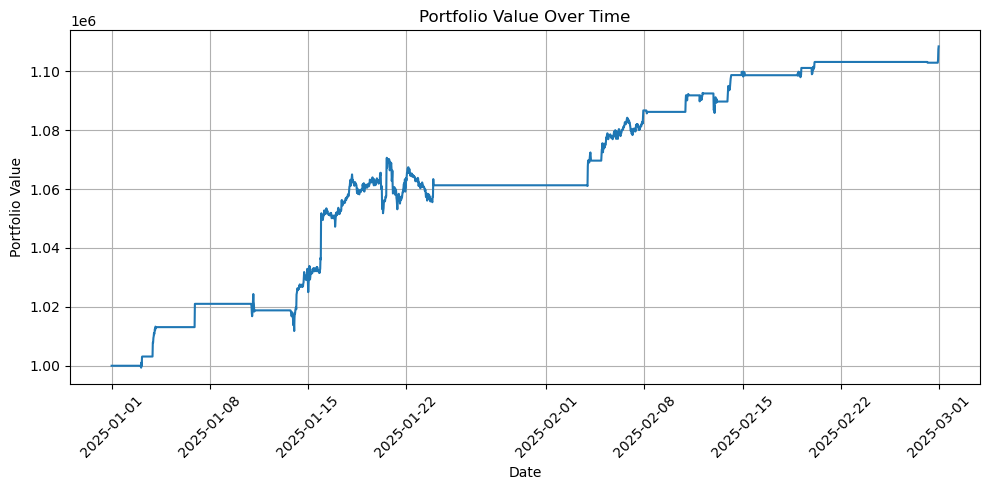

In [13]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(combined['Date'], combined['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

## Shared cash pool

In [14]:
merged_combined = merged.merge(merged_spy, how = 'left', on = 'Date')
# Renaming columns in the DataFrame
merged_combined = merged_combined.rename(columns=lambda x: x.replace('_x', '_BTC').replace('_y', '_SPY'))
merged_combined

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open_BTC,Open_lag1_BTC,High_lag1_BTC,Low_lag1_BTC,SMAVG (5) on Close_lag1_BTC,SMAVG (10) on Close_lag1_BTC,...,SMAVG (15) on Close_lag1_SPY,Volume_lag1,MA200_lag1_SPY,MA20_lag1,MA50_lag1_SPY,STD15_lag1_SPY,BB_Upper_lag1_SPY,BB_Lower_lag1_SPY,BB_Width_lag1_SPY,Vol_Mean_lag1
0,2025-01-01 00:00:00,94819.27,95000.13016,95282.72,95284.25,95437.91,95844.62,95204.09,95488.11,95013.40,...,589.310,1100546.0,599.799950,590.12875,595.25706,3.432060,596.992870,583.264630,0.023295,2550729.20
1,2025-01-01 00:30:00,94687.97,94644.51788,94819.27,94819.27,95284.25,95437.53,94810.92,95361.44,95103.27,...,589.450,1592798.0,599.698850,589.77425,595.01046,2.984927,595.744104,583.804396,0.020256,2545687.70
2,2025-01-01 01:00:00,94358.80,94750.07166,94687.97,94686.97,94819.27,94824.27,94497.53,95154.90,95163.72,...,589.450,1192807.0,599.597500,589.36475,594.77066,2.853206,595.071161,583.658339,0.019362,2524031.85
3,2025-01-01 01:30:00,93961.69,94338.51126,94358.80,94358.80,94686.97,94864.25,94343.75,94916.59,95134.91,...,589.312,1309514.0,599.488900,588.98175,594.48526,2.942816,594.867382,583.096118,0.019975,2503616.85
4,2025-01-01 02:00:00,93836.11,93863.01374,93961.69,93961.44,94358.80,94379.84,93090.16,94622.09,95089.80,...,589.172,2380319.0,599.385875,588.59150,594.20336,2.924580,594.440660,582.742340,0.019856,2035376.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2827,2025-02-28 21:30:00,81465.09,82093.36098,80695.28,80695.28,80744.59,81344.80,80576.77,80526.28,80204.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2828,2025-02-28 22:00:00,81785.98,82832.43628,81465.09,81468.81,80695.28,81674.88,80673.88,80706.39,80461.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2829,2025-02-28 22:30:00,82054.27,82792.20484,81785.98,81787.52,81468.81,82321.16,81467.95,80968.56,80604.88,...,592.209,11633014.0,603.443895,592.55525,595.13394,3.241304,599.037859,586.072641,0.021893,2960406.25
2830,2025-02-28 23:00:00,84317.02,83402.23912,82054.27,82054.27,81787.52,82492.67,81055.78,81348.77,80781.33,...,591.697,6418951.0,603.358470,592.07150,594.89684,3.565169,599.201838,584.941162,0.024101,3187313.25


In [15]:
merged_combined.columns

Index(['Date', 'BTC_Actual', 'BTC_Predicted', 'BTC_PrevClose', 'Open_BTC',
       'Open_lag1_BTC', 'High_lag1_BTC', 'Low_lag1_BTC',
       'SMAVG (5)  on Close_lag1_BTC', 'SMAVG (10)  on Close_lag1_BTC',
       'SMAVG (15)  on Close_lag1_BTC', 'MA200_lag1_BTC', 'MA50_lag1_BTC',
       'STD15_lag1_BTC', 'BB_Upper_lag1_BTC', 'BB_Lower_lag1_BTC',
       'BB_Width_lag1_BTC', 'SPY_Actual', 'SPY_Predicted', 'SPY_PrevClose',
       'Open_SPY', 'Open_lag1_SPY', 'High_lag1_SPY', 'Low_lag1_SPY',
       'SMAVG (5)  on Close_lag1_SPY', 'SMAVG (10)  on Close_lag1_SPY',
       'SMAVG (15)  on Close_lag1_SPY', 'Volume_lag1', 'MA200_lag1_SPY',
       'MA20_lag1', 'MA50_lag1_SPY', 'STD15_lag1_SPY', 'BB_Upper_lag1_SPY',
       'BB_Lower_lag1_SPY', 'BB_Width_lag1_SPY', 'Vol_Mean_lag1'],
      dtype='object')

In [16]:
import pandas as pd
import numpy as np

# Initial settings
initial_cash = 1000000  # Total starting cash for both assets
commission_spy = 0.0003
commission_btc = 0.0005
stop_loss_pct_btc = 0.07  # 7% stop loss
stop_loss_pct_spy = 0.05  # 5% stop loss

# Copy merged dataset with both SPY and BTC data
trading_results = merged_combined.copy().reset_index(drop=True)
trading_results['Predicted_Diff_BTC'] = trading_results['BTC_Predicted'] / trading_results['Open_BTC'] - 1
trading_results['Predicted_Diff_SPY'] = trading_results['SPY_Predicted'] / trading_results['Open_SPY'] - 1

# Initialize portfolio variables
cash = initial_cash
position_spy = 0
position_btc = 0
entry_price_spy = None
entry_price_btc = None
total_commission = 0

# Add tracking columns
trading_results['Cash'] = cash
trading_results['Position_SPY'] = 0
trading_results['Position_BTC'] = 0
trading_results['Portfolio_Value'] = cash
trading_results['Trade_Action_SPY'] = 'Hold'
trading_results['Trade_Action_BTC'] = 'Hold'

# Initialize tracking variable for last known SPY price
prev_spy_price = None  
trading_results['BB_Lower_lag1_SPY'] = trading_results['BB_Lower_lag1_SPY'].ffill()
trading_results['BB_Upper_lag1_SPY'] = trading_results['BB_Upper_lag1_SPY'].ffill() # forward fill because need to access i-1 later on when necessary

for i in range(1, len(trading_results)):
    current_time = trading_results['Date'].iloc[i]
    
    # SPY data
    current_spy_price = trading_results['SPY_Actual'].iloc[i]
    current_spy_open = trading_results['Open_SPY'].iloc[i]
    lowerbb_spy = trading_results['BB_Lower_lag1_SPY'].iloc[i]
    upperbb_spy = trading_results['BB_Upper_lag1_SPY'].iloc[i]
    prev_vol_spy = trading_results['Volume_lag1'].iloc[i]
    vol_mean_spy = trading_results['Vol_Mean_lag1'].iloc[i]
    prev_lowerbb_spy = trading_results.at[i-1, 'BB_Lower_lag1_SPY']
    prev_upperbb_spy = trading_results.at[i-1, 'BB_Upper_lag1_SPY']
    volatility_spy = trading_results.at[i, 'STD15_lag1_SPY']

    # BTC data
    current_btc_price = trading_results['BTC_Actual'].iloc[i]
    current_btc_open = trading_results['Open_BTC'].iloc[i]
    lowerbb_btc = trading_results['BB_Lower_lag1_BTC'].iloc[i]
    upperbb_btc = trading_results['BB_Upper_lag1_BTC'].iloc[i]
    prev_ma50_btc = trading_results['MA50_lag1_BTC'].iloc[i]
    prev_ma200_btc = trading_results['MA200_lag1_BTC'].iloc[i]
    prev_ma10_btc = trading_results.at[i, 'SMAVG (10)  on Close_lag1_BTC']
    prev_ma15_btc = trading_results.at[i, 'SMAVG (15)  on Close_lag1_BTC']

    # Generate trading signals for SPY (only during market hours)
    spy_signal = 0
    if not pd.isna(current_spy_price):  # Check if SPY is trading
        # Generate trading signals
        if trading_results.at[i, 'Predicted_Diff_SPY'] > 0 and current_spy_open < lowerbb_spy * 1.0008 and ((lowerbb_spy - prev_lowerbb_spy) * (upperbb_spy - prev_upperbb_spy)) < 0 and volatility_spy < 4: 
            spy_signal = 1  # Buy signal
        elif trading_results.at[i, 'Predicted_Diff_SPY'] < 0 and current_spy_open > upperbb_spy and prev_vol_spy > vol_mean_spy:
            spy_signal = -1  # Sell signal

    # Generate trading signals for BTC
    btc_signal = 0
    if trading_results.at[i, 'Predicted_Diff_BTC'] > 0.003 and current_btc_open <= lowerbb_btc and prev_ma50_btc > prev_ma200_btc and prev_ma10_btc < prev_ma15_btc: 
        btc_signal = 1
    elif trading_results.at[i, 'Predicted_Diff_BTC'] < -0.0015 and current_btc_open >= upperbb_btc and prev_ma50_btc < prev_ma200_btc:
        btc_signal = -1
        
    ### TRADING LOGIC ###
    
    # SPY Trading (Only during Market Hours)
    if spy_signal == 1 and not pd.isna(current_spy_price) and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.87)  # Allocate max 50% cash to SPY
        buy_units = int(buy_amount / current_spy_price)
        commission = buy_units * current_spy_price * commission_spy
        if buy_units > 0:
            cash -= (buy_units * current_spy_price + commission)
            total_commission += commission
            position_spy += buy_units
            entry_price_spy = current_spy_price if position_spy == buy_units else entry_price_spy
            trading_results.at[i, 'Trade_Action_SPY'] = 'Buy'

    elif spy_signal == -1 and position_spy > 0:  # Sell SPY
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Sell'

    # BTC Trading (24/7)
    if btc_signal == 1 and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.12)  # Allocate max 50% cash to BTC
        buy_units = buy_amount / current_btc_price
        commission = buy_amount * commission_btc
        if buy_units > 0:
            cash -= (buy_amount + commission)
            total_commission += commission
            position_btc += buy_units
            entry_price_btc = current_btc_price if position_btc == buy_units else entry_price_btc
            trading_results.at[i, 'Trade_Action_BTC'] = 'Buy'

    elif btc_signal == -1 and position_btc > 0:  # Sell BTC
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Sell'

    # Stop-loss for SPY
    if position_spy > 0 and current_spy_price < entry_price_spy * (1 - stop_loss_pct_spy):
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Stop-Loss Sell'

    # Stop-loss for BTC
    if position_btc > 0 and current_btc_price < entry_price_btc * (1 - stop_loss_pct_btc):
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Stop-Loss Sell'

    # Carry forward previous SPY price if current price is NaN
    if pd.isna(current_spy_price) and prev_spy_price is not None:
        current_spy_price = prev_spy_price
    elif not pd.isna(current_spy_price):
        prev_spy_price = current_spy_price  # Update previous price if current price is valid

    # Update Portfolio Value
    portfolio_value = cash + (position_spy * current_spy_price if not pd.isna(current_spy_price) else 0) + (position_btc * current_btc_price)
    trading_results.at[i, 'Cash'] = cash
    trading_results.at[i, 'Position_SPY'] = position_spy
    trading_results.at[i, 'Position_BTC'] = position_btc
    trading_results.at[i, 'Portfolio_Value'] = portfolio_value

# Performance metrics
total_return = (trading_results['Portfolio_Value'].iloc[-1] / initial_cash - 1) * 100
num_trades = len(trading_results[(trading_results['Trade_Action_SPY'] != 'Hold') | (trading_results['Trade_Action_BTC'] != 'Hold')])
max_drawdown = ((trading_results['Portfolio_Value'].cummax() - trading_results['Portfolio_Value']) / trading_results['Portfolio_Value'].cummax()).max() * 100

# Print results
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Final Portfolio Value: {trading_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results['Cash'].iloc[-1]:,.2f}")
print(f"Final SPY Position: {trading_results['Position_SPY'].iloc[-1]}")
print(f"Final BTC Position: {trading_results['Position_BTC'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '129977.09140599996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999739.071406' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Portfolio_Value'] = portfolio_value
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:151: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17428723007864322' has dtype incompatible with int

Total Return: 10.12%
Number of Trades: 19
Maximum Drawdown: 2.01%
Final Portfolio Value: 1,101,201.12
Final Cash: 18,839.68
Final SPY Position: 1838
Final BTC Position: 0.0
Total Commission Paid: 2,923.65


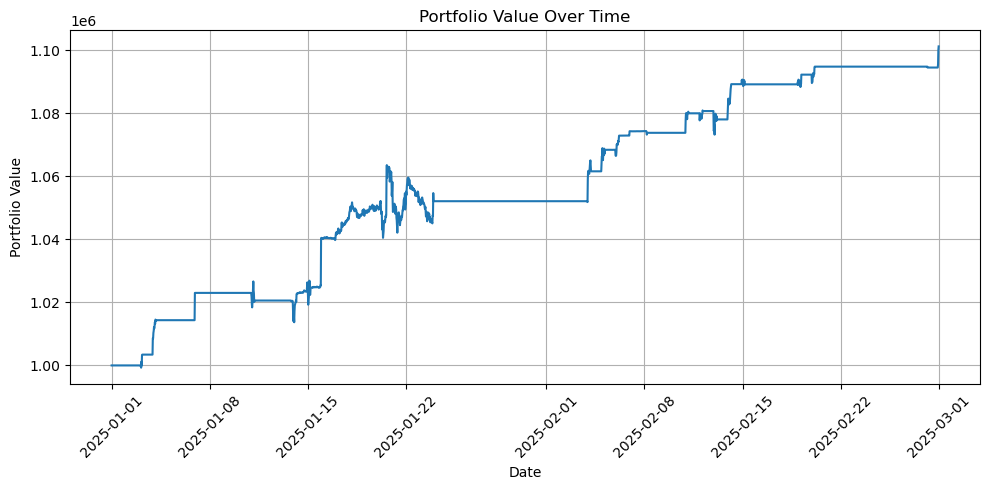

In [17]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results['Date'], trading_results['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

## SPY March

In [18]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

spy['MA200'] = spy['Close'].rolling(window=200).mean()
spy['MA20'] = spy['Close'].rolling(window=20).mean()
spy['MA50'] = spy['Close'].rolling(window=50).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['MA20'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['MA20'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

spy['Vol_Mean'] = spy['Volume'].rolling(20).mean()

# Create lagged columns (shift by 1)
lagged_spy = spy.copy()
for col in spy.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_spy[col + '_lag1'] = spy[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_spy = lagged_spy[['Date', 'Close', 'Open'] + [col + '_lag1' for col in spy.columns if col not in ['Date', 'Close']]]

lagged_spy.drop(index=lagged_spy.index[:30], inplace=True)

In [19]:
spy = pd.read_csv("../data/spy_rf_predictions_rolling_march.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])

merged_spy = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged_spy = merged_spy.drop(columns = ['Unnamed: 0', 'Close', 'SPY_BreakHigh2_lag1'])

In [20]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
trading_results3 = merged_spy.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['SPY_Actual'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100

# Calculate price change predictions
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted'] / trading_results3['Open'] - 1

# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'

for i in range(1, len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    prev_ma200 = trading_results3['MA200_lag1'].iloc[i]
    upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    prev_vol = trading_results3['Volume_lag1'].iloc[i]
    vol_mean = trading_results3['Vol_Mean_lag1'].iloc[i]
    prev_lowerbb = trading_results3.at[i-1, 'BB_Lower_lag1']
    prev_upperbb = trading_results3.at[i-1, 'BB_Upper_lag1']
    volatility = trading_results3.at[i, 'STD15_lag1']

    # Generate trading signals

    if trading_results3.at[i, 'Predicted_Diff'] > 0 and current_open < lowerbb * 1.0008 and ((lowerbb - prev_lowerbb) * (upperbb - prev_upperbb)) < 0 and volatility < 4: 
        trading_results3.at[i, 'Signal'] = 1  # Buy signal
    elif trading_results3.at[i, 'Predicted_Diff'] < 0 and current_open > upperbb and prev_vol > vol_mean:
        trading_results3.at[i, 'Signal'] = -1  # Sell signal

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal == 1 and cash > 5000:  # Buy signal
        max_buy_units = int((cash-5000) / (current_price * (1 + commission_rate)))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 1.25%
Buy-and-Hold Return: -5.18%
Number of Trades: 3
Maximum Drawdown: 2.75%
Final Portfolio Value: 810,006.13
Final Cash: 5,309.09
Final Position: 1448
Total Commission Paid: 734.80


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/2792507533.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5011.574999999953' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/2792507533.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799761.575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value


In [21]:
trading_results3[trading_results3['Trade_Action'] != 'Hold']

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Vol_Mean_lag1,Predicted_Diff,Signal,Position,Cash,Portfolio_Value,Trade_Action
122,2025-03-14 01:30:00,550.000,555.734510,551.01,550.98,552.60,553.34,550.36,552.588,554.948,...,563.119765,550.942335,0.021877,2836305.6,0.008629,1,1445,5011.575000,799761.575000,Buy
205,2025-03-24 21:30:00,572.795,563.815264,563.96,570.80,562.05,564.89,561.73,562.709,562.076,...,568.725181,556.957719,0.020932,3035370.8,-0.012237,-1,0,832452.043367,832452.043367,Sell
236,2025-03-27 00:00:00,571.060,570.896972,570.60,570.64,572.32,572.79,570.12,572.638,573.533,...,576.445925,571.959375,0.007817,2408113.5,0.000450,1,1448,5309.094903,832203.974903,Buy


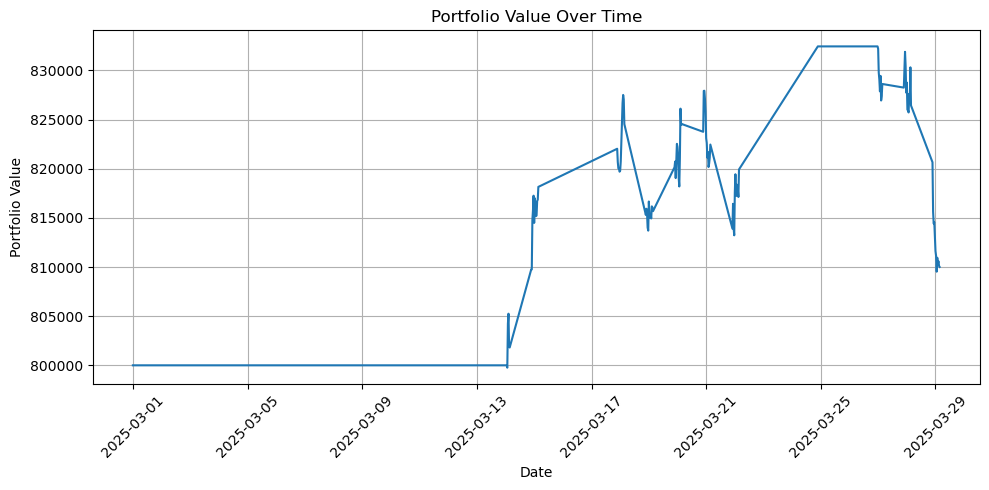

In [22]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

## BTC March

In [23]:
btc = pd.read_excel('../data/pricing_data.xlsx', sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

btc['MA200'] = btc['Close'].rolling(window=200).mean()
btc['MA50'] = btc['Close'].rolling(window=50).mean()

# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
btc['STD15'] = btc['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
btc['BB_Upper'] = btc['SMAVG (15)  on Close'] + (btc['STD15'] * 2)
btc['BB_Lower'] = btc['SMAVG (15)  on Close'] - (btc['STD15'] * 2)

# Calculate Bollinger Band Width
btc['BB_Width'] = (btc['BB_Upper'] - btc['BB_Lower']) / btc['SMAVG (15)  on Close']

# Create lagged columns (shift by 1)
lagged_btc = btc.copy()
for col in btc.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_btc[col + '_lag1'] = btc[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_btc = lagged_btc[['Date', 'Close', 'Open'] + [col + '_lag1' for col in btc.columns if col not in ['Date', 'Close']]]

lagged_btc.drop(index=lagged_btc.index[:30], inplace=True)

lagged_btc = lagged_btc[lagged_btc['Date'] >= '2025-03-01']

btc = pd.read_csv("../data/btc_rf_predictions_rolling_march.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = btc.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'BTC_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_btc = btc.rename(columns=rename_dict)

df_btc["Date"] = pd.to_datetime(df_btc["Date"])

merged = df_btc.merge(lagged_btc, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'BTC_BreakHigh2_lag1'])

In [24]:
import pandas as pd
import numpy as np

# Initial investment and parameters
initial_investment = 200000
commission_rate = 0.0005
trading_results2 = merged.copy().reset_index(drop=True)

# Calculate price change predictions
trading_results2['Predicted_Diff'] = trading_results2['BTC_Predicted'] / trading_results2['Open'] - 1

# Create trading signals
trading_results2['Signal'] = 0

# Initialize portfolio columns
trading_results2['Position'] = 0
trading_results2['Cash'] = initial_investment
trading_results2['Entry_Price'] = 0
trading_results2['Portfolio_Value'] = initial_investment
trading_results2['Trade_Action'] = 'Hold'

# Initialize variables
position = 0
entry_price = 0
cash = initial_investment
total_commission = 0
stop_loss_pct = 0.07  # 7% stop-loss

for i in range(1, len(trading_results2)):
    prev_close = trading_results2.at[i-1, 'BTC_Actual']
    current_open = trading_results2.at[i, 'Open']
    prev_high = trading_results2.at[i-1, 'High_lag1']
    prev_low = trading_results2.at[i-1, 'Low_lag1']
    prev_ma200 = trading_results2.at[i, 'MA200_lag1']
    prev_ma50 = trading_results2.at[i, 'MA50_lag1']
    prev_ma10 = trading_results2.at[i, 'SMAVG (10)  on Close_lag1']
    prev_ma15 = trading_results2.at[i, 'SMAVG (15)  on Close_lag1']
    lowerbb = trading_results2.at[i, 'BB_Lower_lag1']
    upperbb = trading_results2.at[i, 'BB_Upper_lag1']

    if trading_results2.at[i, 'Predicted_Diff'] > 0.003 and current_open <= lowerbb and prev_ma50 > prev_ma200 and prev_ma10 < prev_ma15: 
        trading_results2.at[i, 'Signal'] = 1
    elif trading_results2.at[i, 'Predicted_Diff'] < -0.0015 and current_open >= upperbb and prev_ma50 < prev_ma200:
        trading_results2.at[i, 'Signal'] = -1

    current_price = trading_results2['BTC_Actual'].iloc[i]
    current_signal = trading_results2['Signal'].iloc[i]

    # Trading logic
    if current_signal == 1 and cash > 5000:  # Buy
        buy_amount = cash - 5000
        buy_units = buy_amount / current_price
        commission = buy_amount * commission_rate
        total_commission += commission
        
        if position == 0:
            entry_price = current_price
            trading_results2.at[i, 'Trade_Action'] = 'Buy'
        else:
            trading_results2.at[i, 'Trade_Action'] = 'Add Long'
            entry_price = (entry_price * position + current_price * buy_units) / (position + buy_units)  # Adjust entry price
        
        position += buy_units
        cash -= (buy_amount + commission)

    elif current_signal == -1 and position > 0:  # Sell
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Sell'

    # Implement stop-loss: if price falls 5% below entry price, sell
    if position > 0 and current_price <= entry_price * (1 - stop_loss_pct):
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission

        cash += sell_amount - commission
        position = 0
        entry_price = 0
        trading_results2.at[i, 'Trade_Action'] = 'Stop-Loss Sell'

    # Update Portfolio Value
    portfolio_value = cash + position * current_price
    trading_results2.at[i, 'Position'] = position
    trading_results2.at[i, 'Cash'] = cash
    trading_results2.at[i, 'Entry_Price'] = entry_price
    trading_results2.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return = (trading_results2['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results2[trading_results2['Trade_Action'] != 'Hold'])
max_drawdown = (trading_results2['Portfolio_Value'].cummax() - trading_results2['Portfolio_Value']) / trading_results2['Portfolio_Value'].cummax()

print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown.max()*100:.2f}%")
print(f"Final Portfolio Value: {trading_results2['Portfolio_Value'].iloc[-1]:,.2f}")

Total Return: 3.26%
Number of Trades: 4
Maximum Drawdown: 5.51%
Final Portfolio Value: 206,529.43


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/3160502181.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.2395423707634747' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Position'] = position
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/3160502181.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4902.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results2.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/3160502181.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '87071.36' has dtype incompatible with int64, please explicitly cast to a c

In [25]:
trading_results2[trading_results2['Trade_Action'] != 'Hold']

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,Entry_Price,Portfolio_Value,Trade_Action
149,2025-03-04 02:30:00,87071.36,88135.94560,87688.27,87688.23,90253.83,90380.00,87387.36,89703.77,90543.83,...,94104.226237,88517.293763,0.061186,0.005106,1,2.239542,4902.500000,87071.36,199902.500000,Buy
198,2025-03-05 03:00:00,87769.58,86462.33466,86769.19,86769.19,85342.78,86913.20,85139.69,85145.73,83897.38,...,85578.175436,81789.144564,0.045278,-0.003536,-1,0.000000,201367.911427,0.00,201367.911427,Sell
619,2025-03-13 22:00:00,81887.70,82047.90536,81724.72,81724.72,82888.45,83069.06,81602.97,82659.08,82922.41,...,83909.996579,82049.043421,0.022427,0.003955,1,2.398015,4901.816044,81887.70,201269.727472,Buy
819,2025-03-18 02:00:00,84123.12,84028.53872,84192.97,84192.97,83926.34,84335.31,83832.62,83737.80,83365.75,...,83995.382170,82708.577830,0.015438,-0.001953,-1,0.000000,206529.433336,0.00,206529.433336,Sell


## Shared cash pool

In [26]:
merged_combined = merged.merge(merged_spy, how = 'left', on = 'Date')
# Renaming columns in the DataFrame
merged_combined = merged_combined.rename(columns=lambda x: x.replace('_x', '_BTC').replace('_y', '_SPY'))
merged_combined

,Date,BTC_Actual,BTC_Predicted,BTC_PrevClose,Open_BTC,Open_lag1_BTC,High_lag1_BTC,Low_lag1_BTC,SMAVG (5) on Close_lag1_BTC,SMAVG (10) on Close_lag1_BTC,...,SMAVG (15) on Close_lag1_SPY,Volume_lag1,MA200_lag1_SPY,MA20_lag1,MA50_lag1_SPY,STD15_lag1_SPY,BB_Upper_lag1_SPY,BB_Lower_lag1_SPY,BB_Width_lag1_SPY,Vol_Mean_lag1
0,2025-03-01 00:00:00,83619.56,85815.88662,84020.59,84020.59,84317.02,84424.28,83739.62,82728.59,81627.44,...,591.062,2266335.0,603.212345,591.6115,594.43724,3.757576,599.126653,584.096347,0.025429,3282617.15
1,2025-03-01 00:30:00,84368.27,85155.58282,83619.56,83618.61,84020.59,84090.72,83503.11,83159.48,81932.94,...,590.430,1940335.0,603.123295,591.2420,594.13524,3.983581,599.209162,583.274838,0.026988,3265584.95
2,2025-03-01 01:00:00,84192.30,85049.54972,84368.27,84368.27,83618.61,84909.19,83599.62,83675.94,82322.25,...,590.025,1421764.0,603.038845,590.9690,593.87014,4.002188,598.973376,582.964624,0.027132,3257610.55
3,2025-03-01 01:30:00,83600.77,84720.85704,84192.30,84193.27,84368.27,84383.75,83865.06,84103.55,82726.16,...,589.556,1229612.0,602.948345,590.6495,593.58434,3.995355,598.640209,582.658791,0.027108,3232371.90
4,2025-03-01 02:00:00,83808.28,84580.73582,83600.77,83600.77,84193.27,84282.23,83585.55,83960.30,83011.91,...,588.955,3094521.0,602.840795,590.0940,593.24124,4.102867,598.299734,581.888266,0.027865,3130070.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,2025-03-29 08:00:00,84507.50,84329.86136,84383.89,84383.89,84197.69,84389.75,84179.44,84241.89,84023.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1360,2025-03-29 08:30:00,84359.25,84391.33874,84507.50,84507.44,84383.89,84526.28,84333.08,84343.40,84100.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1361,2025-03-29 09:00:00,84212.67,84314.84100,84359.25,84359.25,84507.44,84574.97,84328.86,84375.02,84163.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,2025-03-29 09:30:00,84258.75,84217.58746,84212.67,84212.67,84359.25,84465.81,84192.02,84332.20,84201.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
merged_combined.columns

Index(['Date', 'BTC_Actual', 'BTC_Predicted', 'BTC_PrevClose', 'Open_BTC',
       'Open_lag1_BTC', 'High_lag1_BTC', 'Low_lag1_BTC',
       'SMAVG (5)  on Close_lag1_BTC', 'SMAVG (10)  on Close_lag1_BTC',
       'SMAVG (15)  on Close_lag1_BTC', 'MA200_lag1_BTC', 'MA50_lag1_BTC',
       'STD15_lag1_BTC', 'BB_Upper_lag1_BTC', 'BB_Lower_lag1_BTC',
       'BB_Width_lag1_BTC', 'SPY_Actual', 'SPY_Predicted', 'SPY_PrevClose',
       'Open_SPY', 'Open_lag1_SPY', 'High_lag1_SPY', 'Low_lag1_SPY',
       'SMAVG (5)  on Close_lag1_SPY', 'SMAVG (10)  on Close_lag1_SPY',
       'SMAVG (15)  on Close_lag1_SPY', 'Volume_lag1', 'MA200_lag1_SPY',
       'MA20_lag1', 'MA50_lag1_SPY', 'STD15_lag1_SPY', 'BB_Upper_lag1_SPY',
       'BB_Lower_lag1_SPY', 'BB_Width_lag1_SPY', 'Vol_Mean_lag1'],
      dtype='object')

In [28]:
import pandas as pd
import numpy as np

# Initial settings
initial_cash = 1000000  # Total starting cash for both assets
commission_spy = 0.0003
commission_btc = 0.0005
stop_loss_pct_btc = 0.07  # 7% stop loss
stop_loss_pct_spy = 0.05  # 5% stop loss

# Copy merged dataset with both SPY and BTC data
trading_results = merged_combined.copy().reset_index(drop=True)
trading_results['Predicted_Diff_BTC'] = trading_results['BTC_Predicted'] / trading_results['Open_BTC'] - 1
trading_results['Predicted_Diff_SPY'] = trading_results['SPY_Predicted'] / trading_results['Open_SPY'] - 1

# Initialize portfolio variables
cash = initial_cash
position_spy = 0
position_btc = 0
entry_price_spy = None
entry_price_btc = None
total_commission = 0

# Add tracking columns
trading_results['Cash'] = cash
trading_results['Position_SPY'] = 0
trading_results['Position_BTC'] = 0
trading_results['Portfolio_Value'] = cash
trading_results['Trade_Action_SPY'] = 'Hold'
trading_results['Trade_Action_BTC'] = 'Hold'

# Initialize tracking variable for last known SPY price
prev_spy_price = None  
trading_results['BB_Lower_lag1_SPY'] = trading_results['BB_Lower_lag1_SPY'].ffill()
trading_results['BB_Upper_lag1_SPY'] = trading_results['BB_Upper_lag1_SPY'].ffill() # forward fill because need to access i-1 later on when necessary

for i in range(1, len(trading_results)):
    current_time = trading_results['Date'].iloc[i]
    
    # SPY data
    current_spy_price = trading_results['SPY_Actual'].iloc[i]
    current_spy_open = trading_results['Open_SPY'].iloc[i]
    lowerbb_spy = trading_results['BB_Lower_lag1_SPY'].iloc[i]
    upperbb_spy = trading_results['BB_Upper_lag1_SPY'].iloc[i]
    prev_vol_spy = trading_results['Volume_lag1'].iloc[i]
    vol_mean_spy = trading_results['Vol_Mean_lag1'].iloc[i]
    prev_lowerbb_spy = trading_results.at[i-1, 'BB_Lower_lag1_SPY']
    prev_upperbb_spy = trading_results.at[i-1, 'BB_Upper_lag1_SPY']
    volatility_spy = trading_results.at[i, 'STD15_lag1_SPY']

    # BTC data
    current_btc_price = trading_results['BTC_Actual'].iloc[i]
    current_btc_open = trading_results['Open_BTC'].iloc[i]
    lowerbb_btc = trading_results['BB_Lower_lag1_BTC'].iloc[i]
    upperbb_btc = trading_results['BB_Upper_lag1_BTC'].iloc[i]
    prev_ma50_btc = trading_results['MA50_lag1_BTC'].iloc[i]
    prev_ma200_btc = trading_results['MA200_lag1_BTC'].iloc[i]
    prev_ma10_btc = trading_results.at[i, 'SMAVG (10)  on Close_lag1_BTC']
    prev_ma15_btc = trading_results.at[i, 'SMAVG (15)  on Close_lag1_BTC']

    # Generate trading signals for SPY (only during market hours)
    spy_signal = 0
    if not pd.isna(current_spy_price):  # Check if SPY is trading
        # Generate trading signals
        if trading_results.at[i, 'Predicted_Diff_SPY'] > 0 and current_spy_open < lowerbb_spy * 1.0008 and ((lowerbb_spy - prev_lowerbb_spy) * (upperbb_spy - prev_upperbb_spy)) < 0 and volatility_spy < 4: 
            spy_signal = 1  # Buy signal
        elif trading_results.at[i, 'Predicted_Diff_SPY'] < 0 and current_spy_open > upperbb_spy and prev_vol_spy > vol_mean_spy:
            spy_signal = -1  # Sell signal

    # Generate trading signals for BTC
    btc_signal = 0
    if trading_results.at[i, 'Predicted_Diff_BTC'] > 0.003 and current_btc_open <= lowerbb_btc and prev_ma50_btc > prev_ma200_btc and prev_ma10_btc < prev_ma15_btc: 
        btc_signal = 1
    elif trading_results.at[i, 'Predicted_Diff_BTC'] < -0.0015 and current_btc_open >= upperbb_btc and prev_ma50_btc < prev_ma200_btc:
        btc_signal = -1
        
    ### TRADING LOGIC ###
    
    # SPY Trading (Only during Market Hours)
    if spy_signal == 1 and not pd.isna(current_spy_price) and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.87)  # Allocate max 50% cash to SPY
        buy_units = int(buy_amount / current_spy_price)
        commission = buy_units * current_spy_price * commission_spy
        if buy_units > 0:
            cash -= (buy_units * current_spy_price + commission)
            total_commission += commission
            position_spy += buy_units
            entry_price_spy = current_spy_price if position_spy == buy_units else entry_price_spy
            trading_results.at[i, 'Trade_Action_SPY'] = 'Buy'

    elif spy_signal == -1 and position_spy > 0:  # Sell SPY
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Sell'

    # BTC Trading (24/7)
    if btc_signal == 1 and cash > 10000:
        buy_amount = min(cash - 10000, cash * 0.12)  # Allocate max 50% cash to BTC
        buy_units = buy_amount / current_btc_price
        commission = buy_amount * commission_btc
        if buy_units > 0:
            cash -= (buy_amount + commission)
            total_commission += commission
            position_btc += buy_units
            entry_price_btc = current_btc_price if position_btc == buy_units else entry_price_btc
            trading_results.at[i, 'Trade_Action_BTC'] = 'Buy'

    elif btc_signal == -1 and position_btc > 0:  # Sell BTC
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Sell'

    # Stop-loss for SPY
    if position_spy > 0 and current_spy_price < entry_price_spy * (1 - stop_loss_pct_spy):
        sell_amount = position_spy * current_spy_price
        commission = sell_amount * commission_spy
        total_commission += commission
        cash += sell_amount - commission
        position_spy = 0
        entry_price_spy = None
        trading_results.at[i, 'Trade_Action_SPY'] = 'Stop-Loss Sell'

    # Stop-loss for BTC
    if position_btc > 0 and current_btc_price < entry_price_btc * (1 - stop_loss_pct_btc):
        sell_amount = position_btc * current_btc_price
        commission = sell_amount * commission_btc
        total_commission += commission
        cash += sell_amount - commission
        position_btc = 0
        entry_price_btc = None
        trading_results.at[i, 'Trade_Action_BTC'] = 'Stop-Loss Sell'

    # Carry forward previous SPY price if current price is NaN
    if pd.isna(current_spy_price) and prev_spy_price is not None:
        current_spy_price = prev_spy_price
    elif not pd.isna(current_spy_price):
        prev_spy_price = current_spy_price  # Update previous price if current price is valid

    # Update Portfolio Value
    portfolio_value = cash + (position_spy * current_spy_price if not pd.isna(current_spy_price) else 0) + (position_btc * current_btc_price)
    trading_results.at[i, 'Cash'] = cash
    trading_results.at[i, 'Position_SPY'] = position_spy
    trading_results.at[i, 'Position_BTC'] = position_btc
    trading_results.at[i, 'Portfolio_Value'] = portfolio_value

# Performance metrics
total_return = (trading_results['Portfolio_Value'].iloc[-1] / initial_cash - 1) * 100
num_trades = len(trading_results[(trading_results['Trade_Action_SPY'] != 'Hold') | (trading_results['Trade_Action_BTC'] != 'Hold')])
max_drawdown = ((trading_results['Portfolio_Value'].cummax() - trading_results['Portfolio_Value']) / trading_results['Portfolio_Value'].cummax()).max() * 100

# Print results
print(f"Total Return: {total_return:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Final Portfolio Value: {trading_results['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results['Cash'].iloc[-1]:,.2f}")
print(f"Final SPY Position: {trading_results['Position_SPY'].iloc[-1]}")
print(f"Final BTC Position: {trading_results['Position_BTC'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:151: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3781799204698306' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Position_BTC'] = position_btc
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:152: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999786.4431932613' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results.at[i, 'Portfolio_Value'] = portfolio_value
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_65274/1103160059.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1000841.7916476784' has dtype in

Total Return: 1.40%
Number of Trades: 14
Maximum Drawdown: 2.71%
Final Portfolio Value: 1,014,032.28
Final Cash: 10,383.90
Final SPY Position: 1806
Final BTC Position: 0.0
Total Commission Paid: 1,162.49


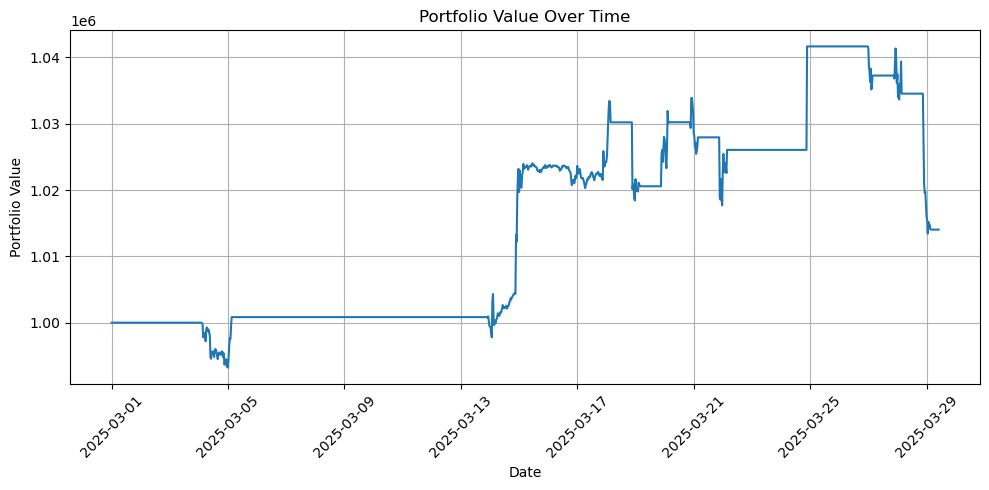

In [29]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results['Date'], trading_results['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()